Downloaded raw/transactions/transactions_20250824.csv from R2
Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBal

<Figure size 1000x400 with 0 Axes>

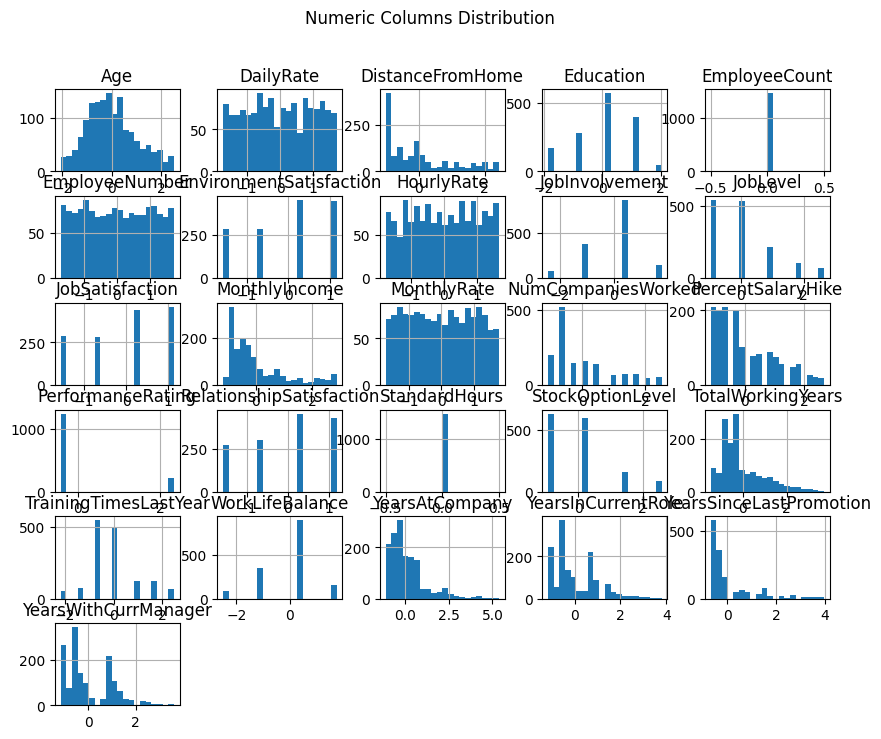

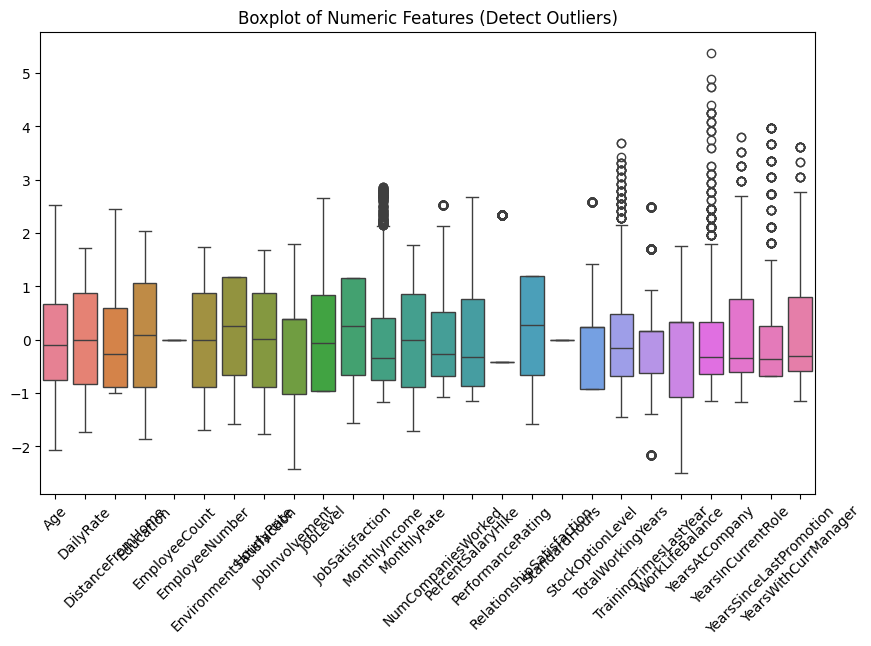

Cleaned data saved locally as transactions_20250824_clean.csv
Uploaded cleaned data to R2 at processed/transactions/transactions_20250824_clean.csv


In [2]:
# Install boto3 if in Colab
!pip install boto3

import boto3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from botocore.client import Config
from datetime import datetime

# --- R2 Setup ---
R2_ACCOUNT_ID = '5888fa452f98b643869ab913fdb46b76'
R2_BUCKET = 'dmml'
R2_ACCESS_KEY_ID = '112fbd48952511129d81eb3540972a44'
R2_SECRET_ACCESS_KEY = 'b63191c3a3886afabb0bd92ace8a59382cba1eeef08c9bfa7a6204c72a3c219a'
R2_ENDPOINT = f'https://5888fa452f98b643869ab913fdb46b76.r2.cloudflarestorage.com'

r2 = boto3.client(
    service_name='s3',
    aws_access_key_id=R2_ACCESS_KEY_ID,
    aws_secret_access_key=R2_SECRET_ACCESS_KEY,
    endpoint_url=R2_ENDPOINT,
    config=Config(signature_version='s3v4'))

today = datetime.now().strftime('%Y%m%d')

def fetch_csv_from_r2(r2_bucket, source, prefix='raw/transactions'):
    r2_key = f"{prefix}/{source}_{today}.csv"
    local_tmp = f"{source}_{today}.csv"
    r2.download_file(r2_bucket, r2_key, local_tmp)
    print(f"Downloaded {r2_key} from R2")
    return local_tmp

# Fetch and load data (example for transactions, change prefix/source for customers)
csv_file = fetch_csv_from_r2(R2_BUCKET, source='transactions', prefix='raw/transactions')
df = pd.read_csv(csv_file)

# --- HANDLE MISSING VALUES ---
print("Missing values per column:")
print(df.isnull().sum())
df_clean = df.dropna(thresh=len(df.columns)-2)   # drop rows missing more than 2 cols

num_cols = df_clean.select_dtypes(include=np.number).columns
cat_cols = df_clean.select_dtypes(exclude=np.number).columns

for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# --- STANDARDIZATION/ NORMALIZATION ---
scaler = StandardScaler()
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])

# --- ENCODE CATEGORICALS ---
for col in cat_cols:
    if df_clean[col].nunique() == 2:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col])
    else:
        df_clean = pd.get_dummies(df_clean, columns=[col], drop_first=True)

# --- EDA: SUMMARY AND VISUALIZATION ---
print("\nSummary statistics:")
print(df_clean.describe())

plt.figure(figsize=(10,4))
df_clean[num_cols].hist(bins=20, figsize=(10,8))
plt.suptitle('Numeric Columns Distribution')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_clean[num_cols])
plt.title('Boxplot of Numeric Features (Detect Outliers)')
plt.xticks(rotation=45)
plt.show()

# Update cat_cols to reflect the columns in df_clean after one-hot encoding
cat_cols_clean = df_clean.select_dtypes(include='uint8').columns

for col in cat_cols_clean[:5]:  # only a few for visualization
    plt.figure()
    sns.countplot(x=df_clean[col])
    plt.title(f'Distribution of {col}')
    plt.show()

# --- SAVE AND UPLOAD CLEAN DATA ---
clean_file = f"{csv_file.replace('.csv', '')}_clean.csv"
df_clean.to_csv(clean_file, index=False)
print(f"Cleaned data saved locally as {clean_file}")

# Upload clean dataset to R2
r2_clean_key = f"processed/transactions/transactions_{today}_clean.csv"
r2.upload_file(clean_file, R2_BUCKET, r2_clean_key)
print(f"Uploaded cleaned data to R2 at {r2_clean_key}")

# Clean up temp local files if desired
# os.remove(csv_file)
# os.remove(clean_file)